# Predictor

# 0.0. Imports

In [31]:
import json
import os
import numpy   as np
import pandas  as pd
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.pylab  as plb
%matplotlib inline
pd.set_option("display.max_columns", 700)

from sklearn.preprocessing    import StandardScaler, MinMaxScaler, LabelEncoder
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.ensemble         import RandomForestRegressor
from sklearn.metrics          import mean_squared_log_error, mean_squared_error, mean_absolute_error
from sklearn.linear_model     import Ridge

## 0.1. Carregando configurações do arquivo json

In [2]:
stock_dic = {
                1: 'win',
                2: 'wdo',
                3: 'abev3',
                4: 'b3sa3',
                5: 'bbas3',
                6: 'bbdc4',
                7: 'itub4',
                8: 'petr4',
                9: 'vale3'
            }

In [3]:
configs = json.load(open('config_modelo.json', 'r'))
filepath = configs['dataset']['filepath']
filename = configs['dataset']['filename']
horizon = configs['dataset']['horizon']

In [4]:
# Carregar o Dataset
df = pd.read_pickle(filepath+filename)
df.head()

,DATETIME,DATE_1,TIME_1,OPEN_1,HIGH_1,LOW_1,CLOSE_1,VOL_1,BBANDS_Upper_5_1,BBANDS_Lower_5_1,BBANDS_Upper_10_1,BBANDS_Lower_10_1,BBANDS_Upper_20_1,BBANDS_Lower_20_1,DEMA_20_1,EMA_20_1,MIDPOINT_3_1,MIDPOINT_12_1,MIDPRICE_3_1,MIDPRICE_12_1,SAR_2_1,SAR_6_1,SAR_10_1,SAR_14_1,SAR_18_1,TEMA_5_1,TRIMA_5_1,TRIMA_10_1,TRIMA_20_1,WMA_5_1,WMA_10_1,WMA_20_1,ADX_3_1,ADX_6_1,ADX_10_1,APO_3_12_1,APO_5_12_1,BOP_1,CCI_3_1,CCI_6_1,CCI_12_1,CCI_20_1,MFI_3_1,MFI_6_1,MFI_12_1,MOM_3_1,MOM_6_1,MOM_10_1,MOM_14_1,PPO_3_12_1,PPO_12_20_1,ROC_3_1,ROC_5_1,ROC_7_1,ROC_10_1,RSI_3_1,RSI_6_1,RSI_10_1,RSI_14_1,TRIX_3_1,TRIX_5_1,TRIX_7_1,AD_1,ADOSC_1,OBV_1,ATR_3_1,ATR_6_1,ATR_12_1,ATR_20_1,TRANGE_1,MES_1,DIA_SEMANA_1,SEMANA_DO_ANO_1,DATE_2,TIME_2,OPEN_2,HIGH_2,LOW_2,CLOSE_2,VOL_2,BBANDS_Upper_5_2,BBANDS_Lower_5_2,BBANDS_Upper_10_2,BBANDS_Lower_10_2,BBANDS_Upper_20_2,BBANDS_Lower_20_2,DEMA_20_2,EMA_20_2,MIDPOINT_3_2,MIDPOINT_12_2,MIDPRICE_3_2,MIDPRICE_12_2,SAR_2_2,SAR_6_2,SAR_10_2,SAR_14_2,SAR_18_2,TEMA_5_2,TRIMA_5_2,TRIMA_10_2,TRIMA_20_2,WMA_5_2,WMA_10_2,WMA_20_2,ADX_3_2,ADX_6_2,ADX_10_2,APO_3_12_2,APO_5_12_2,BOP_2,CCI_3_2,CCI_6_2,CCI_12_2,CCI_20_2,MFI_3_2,MFI_6_2,MFI_12_2,MOM_3_2,MOM_6_2,MOM_10_2,MOM_14_2,PPO_3_12_2,PPO_12_20_2,ROC_3_2,ROC_5_2,ROC_7_2,ROC_10_2,RSI_3_2,RSI_6_2,RSI_10_2,RSI_14_2,TRIX_3_2,TRIX_5_2,TRIX_7_2,AD_2,ADOSC_2,OBV_2,ATR_3_2,ATR_6_2,ATR_12_2,ATR_20_2,TRANGE_2,MES_2,DIA_SEMANA_2,SEMANA_DO_ANO_2,DATE_3,TIME_3,OPEN_3,HIGH_3,LOW_3,CLOSE_3,VOL_3,BBANDS_Upper_5_3,BBANDS_Lower_5_3,BBANDS_Upper_10_3,BBANDS_Lower_10_3,BBANDS_Upper_20_3,BBANDS_Lower_20_3,DEMA_20_3,EMA_20_3,MIDPOINT_3_3,MIDPOINT_12_3,MIDPRICE_3_3,MIDPRICE_12_3,SAR_2_3,SAR_6_3,SAR_10_3,SAR_14_3,SAR_18_3,TEMA_5_3,TRIMA_5_3,TRIMA_10_3,TRIMA_20_3,WMA_5_3,WMA_10_3,WMA_20_3,ADX_3_3,ADX_6_3,ADX_10_3,APO_3_12_3,APO_5_12_3,BOP_3,CCI_3_3,CCI_6_3,CCI_12_3,CCI_20_3,MFI_3_3,MFI_6_3,MFI_12_3,MOM_3_3,MOM_6_3,MOM_10_3,MOM_14_3,PPO_3_12_3,PPO_12_20_3,ROC_3_3,ROC_5_3,ROC_7_3,ROC_10_3,RSI_3_3,RSI_6_3,RSI_10_3,RSI_14_3,TRIX_3_3,TRIX_5_3,TRIX_7_3,AD_3,ADOSC_3,OBV_3,ATR_3_3,ATR_6_3,ATR_12_3,ATR_20_3,TRANGE_3,MES_3,DIA_SEMANA_3,SEMANA_DO_ANO_3,DATE_4,TIME_4,OPEN_4,HIGH_4,LOW_4,CLOSE_4,VOL_4,BBANDS_Upper_5_4,BBANDS_Lower_5_4,BBANDS_Upper_10_4,BBANDS_Lower_10_4,BBANDS_Upper_20_4,BBANDS_Lower_20_4,DEMA_20_4,EMA_20_4,MIDPOINT_3_4,MIDPOINT_12_4,MIDPRICE_3_4,MIDPRICE_12_4,SAR_2_4,SAR_6_4,SAR_10_4,SAR_14_4,SAR_18_4,TEMA_5_4,TRIMA_5_4,TRIMA_10_4,TRIMA_20_4,WMA_5_4,WMA_10_4,WMA_20_4,ADX_3_4,ADX_6_4,ADX_10_4,APO_3_12_4,APO_5_12_4,BOP_4,CCI_3_4,CCI_6_4,CCI_12_4,CCI_20_4,MFI_3_4,MFI_6_4,MFI_12_4,MOM_3_4,MOM_6_4,MOM_10_4,MOM_14_4,PPO_3_12_4,PPO_12_20_4,ROC_3_4,ROC_5_4,ROC_7_4,ROC_10_4,RSI_3_4,RSI_6_4,RSI_10_4,RSI_14_4,TRIX_3_4,TRIX_5_4,TRIX_7_4,AD_4,ADOSC_4,OBV_4,ATR_3_4,ATR_6_4,ATR_12_4,ATR_20_4,TRANGE_4,MES_4,DIA_SEMANA_4,SEMANA_DO_ANO_4,DATE_5,TIME_5,OPEN_5,HIGH_5,LOW_5,CLOSE_5,VOL_5,BBANDS_Upper_5_5,BBANDS_Lower_5_5,BBANDS_Upper_10_5,BBANDS_Lower_10_5,BBANDS_Upper_20_5,BBANDS_Lower_20_5,DEMA_20_5,EMA_20_5,MIDPOINT_3_5,MIDPOINT_12_5,MIDPRICE_3_5,MIDPRICE_12_5,SAR_2_5,SAR_6_5,SAR_10_5,SAR_14_5,SAR_18_5,TEMA_5_5,TRIMA_5_5,TRIMA_10_5,TRIMA_20_5,WMA_5_5,WMA_10_5,WMA_20_5,ADX_3_5,ADX_6_5,ADX_10_5,APO_3_12_5,APO_5_12_5,BOP_5,CCI_3_5,CCI_6_5,CCI_12_5,CCI_20_5,MFI_3_5,MFI_6_5,MFI_12_5,MOM_3_5,MOM_6_5,MOM_10_5,MOM_14_5,PPO_3_12_5,PPO_12_20_5,ROC_3_5,ROC_5_5,ROC_7_5,ROC_10_5,RSI_3_5,RSI_6_5,RSI_10_5,RSI_14_5,TRIX_3_5,TRIX_5_5,TRIX_7_5,AD_5,ADOSC_5,OBV_5,ATR_3_5,ATR_6_5,ATR_12_5,ATR_20_5,TRANGE_5,MES_5,DIA_SEMANA_5,SEMANA_DO_ANO_5,DATE_6,TIME_6,OPEN_6,HIGH_6,LOW_6,CLOSE_6,VOL_6,BBANDS_Upper_5_6,BBANDS_Lower_5_6,BBANDS_Upper_10_6,BBANDS_Lower_10_6,BBANDS_Upper_20_6,BBANDS_Lower_20_6,DEMA_20_6,EMA_20_6,MIDPOINT_3_6,MIDPOINT_12_6,MIDPRICE_3_6,MIDPRICE_12_6,SAR_2_6,SAR_6_6,SAR_10_6,SAR_14_6,SAR_18_6,TEMA_5_6,TRIMA_5_6,TRIMA_10_6,TRIMA_20_6,WMA_5_6,WMA_10_6,WMA_20_6,ADX_3_6,ADX_6_6,ADX_10_6,APO_3_12_6,APO_5_12_6,BOP_6,CCI_3_6,CCI_6_6,CCI_12_6,CCI_20_6,MFI_3_6,MFI_6_6,MFI_12_6,MOM_3_6,MOM_6_6,MOM_10_6,MOM_14_6,PPO_3_12_6,PPO_12_20_6

In [5]:
df_pred = df.copy()
for aux in range(9):
    aux += 1
    
    # retirando as colunas de OHL
    df_pred.drop(['DATE_{}'.format(aux),'TIME_{}'.format(aux),\
                  'OPEN_{}'.format(aux), 'HIGH_{}'.format(aux),\
                  'LOW_{}'.format(aux)], axis=1, inplace=True)
    
df_pred.head(2)

,DATETIME,CLOSE_1,VOL_1,BBANDS_Upper_5_1,BBANDS_Lower_5_1,BBANDS_Upper_10_1,BBANDS_Lower_10_1,BBANDS_Upper_20_1,BBANDS_Lower_20_1,DEMA_20_1,EMA_20_1,MIDPOINT_3_1,MIDPOINT_12_1,MIDPRICE_3_1,MIDPRICE_12_1,SAR_2_1,SAR_6_1,SAR_10_1,SAR_14_1,SAR_18_1,TEMA_5_1,TRIMA_5_1,TRIMA_10_1,TRIMA_20_1,WMA_5_1,WMA_10_1,WMA_20_1,ADX_3_1,ADX_6_1,ADX_10_1,APO_3_12_1,APO_5_12_1,BOP_1,CCI_3_1,CCI_6_1,CCI_12_1,CCI_20_1,MFI_3_1,MFI_6_1,MFI_12_1,MOM_3_1,MOM_6_1,MOM_10_1,MOM_14_1,PPO_3_12_1,PPO_12_20_1,ROC_3_1,ROC_5_1,ROC_7_1,ROC_10_1,RSI_3_1,RSI_6_1,RSI_10_1,RSI_14_1,TRIX_3_1,TRIX_5_1,TRIX_7_1,AD_1,ADOSC_1,OBV_1,ATR_3_1,ATR_6_1,ATR_12_1,ATR_20_1,TRANGE_1,MES_1,DIA_SEMANA_1,SEMANA_DO_ANO_1,CLOSE_2,VOL_2,BBANDS_Upper_5_2,BBANDS_Lower_5_2,BBANDS_Upper_10_2,BBANDS_Lower_10_2,BBANDS_Upper_20_2,BBANDS_Lower_20_2,DEMA_20_2,EMA_20_2,MIDPOINT_3_2,MIDPOINT_12_2,MIDPRICE_3_2,MIDPRICE_12_2,SAR_2_2,SAR_6_2,SAR_10_2,SAR_14_2,SAR_18_2,TEMA_5_2,TRIMA_5_2,TRIMA_10_2,TRIMA_20_2,WMA_5_2,WMA_10_2,WMA_20_2,ADX_3_2,ADX_6_2,ADX_10_2,APO_3_12_2,APO_5_12_2,BOP_2,CCI_3_2,CCI_6_2,CCI_12_2,CCI_20_2,MFI_3_2,MFI_6_2,MFI_12_2,MOM_3_2,MOM_6_2,MOM_10_2,MOM_14_2,PPO_3_12_2,PPO_12_20_2,ROC_3_2,ROC_5_2,ROC_7_2,ROC_10_2,RSI_3_2,RSI_6_2,RSI_10_2,RSI_14_2,TRIX_3_2,TRIX_5_2,TRIX_7_2,AD_2,ADOSC_2,OBV_2,ATR_3_2,ATR_6_2,ATR_12_2,ATR_20_2,TRANGE_2,MES_2,DIA_SEMANA_2,SEMANA_DO_ANO_2,CLOSE_3,VOL_3,BBANDS_Upper_5_3,BBANDS_Lower_5_3,BBANDS_Upper_10_3,BBANDS_Lower_10_3,BBANDS_Upper_20_3,BBANDS_Lower_20_3,DEMA_20_3,EMA_20_3,MIDPOINT_3_3,MIDPOINT_12_3,MIDPRICE_3_3,MIDPRICE_12_3,SAR_2_3,SAR_6_3,SAR_10_3,SAR_14_3,SAR_18_3,TEMA_5_3,TRIMA_5_3,TRIMA_10_3,TRIMA_20_3,WMA_5_3,WMA_10_3,WMA_20_3,ADX_3_3,ADX_6_3,ADX_10_3,APO_3_12_3,APO_5_12_3,BOP_3,CCI_3_3,CCI_6_3,CCI_12_3,CCI_20_3,MFI_3_3,MFI_6_3,MFI_12_3,MOM_3_3,MOM_6_3,MOM_10_3,MOM_14_3,PPO_3_12_3,PPO_12_20_3,ROC_3_3,ROC_5_3,ROC_7_3,ROC_10_3,RSI_3_3,RSI_6_3,RSI_10_3,RSI_14_3,TRIX_3_3,TRIX_5_3,TRIX_7_3,AD_3,ADOSC_3,OBV_3,ATR_3_3,ATR_6_3,ATR_12_3,ATR_20_3,TRANGE_3,MES_3,DIA_SEMANA_3,SEMANA_DO_ANO_3,CLOSE_4,VOL_4,BBANDS_Upper_5_4,BBANDS_Lower_5_4,BBANDS_Upper_10_4,BBANDS_Lower_10_4,BBANDS_Upper_20_4,BBANDS_Lower_20_4,DEMA_20_4,EMA_20_4,MIDPOINT_3_4,MIDPOINT_12_4,MIDPRICE_3_4,MIDPRICE_12_4,SAR_2_4,SAR_6_4,SAR_10_4,SAR_14_4,SAR_18_4,TEMA_5_4,TRIMA_5_4,TRIMA_10_4,TRIMA_20_4,WMA_5_4,WMA_10_4,WMA_20_4,ADX_3_4,ADX_6_4,ADX_10_4,APO_3_12_4,APO_5_12_4,BOP_4,CCI_3_4,CCI_6_4,CCI_12_4,CCI_20_4,MFI_3_4,MFI_6_4,MFI_12_4,MOM_3_4,MOM_6_4,MOM_10_4,MOM_14_4,PPO_3_12_4,PPO_12_20_4,ROC_3_4,ROC_5_4,ROC_7_4,ROC_10_4,RSI_3_4,RSI_6_4,RSI_10_4,RSI_14_4,TRIX_3_4,TRIX_5_4,TRIX_7_4,AD_4,ADOSC_4,OBV_4,ATR_3_4,ATR_6_4,ATR_12_4,ATR_20_4,TRANGE_4,MES_4,DIA_SEMANA_4,SEMANA_DO_ANO_4,CLOSE_5,VOL_5,BBANDS_Upper_5_5,BBANDS_Lower_5_5,BBANDS_Upper_10_5,BBANDS_Lower_10_5,BBANDS_Upper_20_5,BBANDS_Lower_20_5,DEMA_20_5,EMA_20_5,MIDPOINT_3_5,MIDPOINT_12_5,MIDPRICE_3_5,MIDPRICE_12_5,SAR_2_5,SAR_6_5,SAR_10_5,SAR_14_5,SAR_18_5,TEMA_5_5,TRIMA_5_5,TRIMA_10_5,TRIMA_20_5,WMA_5_5,WMA_10_5,WMA_20_5,ADX_3_5,ADX_6_5,ADX_10_5,APO_3_12_5,APO_5_12_5,BOP_5,CCI_3_5,CCI_6_5,CCI_12_5,CCI_20_5,MFI_3_5,MFI_6_5,MFI_12_5,MOM_3_5,MOM_6_5,MOM_10_5,MOM_14_5,PPO_3_12_5,PPO_12_20_5,ROC_3_5,ROC_5_5,ROC_7_5,ROC_10_5,RSI_3_5,RSI_6_5,RSI_10_5,RSI_14_5,TRIX_3_5,TRIX_5_5,TRIX_7_5,AD_5,ADOSC_5,OBV_5,ATR_3_5,ATR_6_5,ATR_12_5,ATR_20_5,TRANGE_5,MES_5,DIA_SEMANA_5,SEMANA_DO_ANO_5,CLOSE_6,VOL_6,BBANDS_Upper_5_6,BBANDS_Lower_5_6,BBANDS_Upper_10_6,BBANDS_Lower_10_6,BBANDS_Upper_20_6,BBANDS_Lower_20_6,DEMA_20_6,EMA_20_6,MIDPOINT_3_6,MIDPOINT_12_6,MIDPRICE_3_6,MIDPRICE_12_6,SAR_2_6,SAR_6_6,SAR_10_6,SAR_14_6,SAR_18_6,TEMA_5_6,TRIMA_5_6,TRIMA_10_6,TRIMA_20_6,WMA_5_6,WMA_10_6,WMA_20_6,ADX_3_6,ADX_6_6,ADX_10_6,APO_3_12_6,APO_5_12_6,BOP_6,CCI_3_6,CCI_6_6,CCI_12_6,CCI_20_6,MFI_3_6,MFI_6_6,MFI_12_6,MOM_3_6,MOM_6_6,MOM_10_6,MOM_14_6,PPO_3_12_6,PPO_12_20_6,ROC_3_6,ROC_5_6,ROC_7_6,ROC_10_6,RSI_3_6,RSI_6_6,RSI_10_6,RSI_14_6,TRIX_3_6,TRIX_5_6,TRIX_7_6,AD_6,ADOSC_6,OBV_6,ATR_3_6,ATR_6_6,ATR_12_6,ATR_20_6,TRANGE_6,MES_6,DIA_SEMANA_6,SEMANA_DO_ANO_6,CLOSE_7,VOL_

In [6]:
df_pred['TARGET_WIN_CAT'].value_counts()

HOLD    61365
BUY      8458
SELL     8401
Name: TARGET_WIN_CAT, dtype: int64

In [7]:
df_pred_reg = df_pred.drop(['TARGET_WIN_CAT', 'TARGET_WIN_CAT_ENC'], axis=1)
df_pred_class = df_pred.drop(['TARGET_WIN_CAT', 'TARGET_WIN'], axis=1)

In [8]:
df_pred_reg[['CLOSE_1','TARGET_WIN']].describe()

,CLOSE_1,TARGET_WIN
count,78224.000000,78224.000000
mean,86276.631213,1.547607
std,15439.564485,281.792348
min,58055.000000,-10050.000000
25%,74025.000000,-90.000000
50%,85340.000000,0.000000
75%,98930.000000,90.000000
max,119805.000000,7210.000000


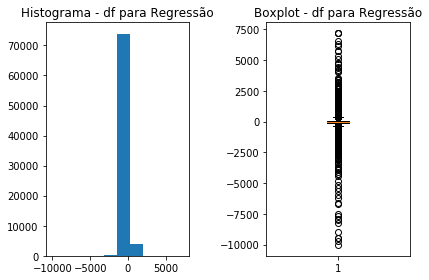

In [9]:
plt.figure(1)

plt.subplot(1,2,1)
plt.hist(df_pred_reg['TARGET_WIN'])
plt.title('Histograma - df para Regressão')

plt.subplot(1,2,2)
plt.boxplot(df_pred_reg['TARGET_WIN'])
plt.title('Boxplot - df para Regressão')

plt.tight_layout()

# Previsão Utilizando Regressão

## Train Test Split

In [10]:
df_train = df_pred_reg[(df_pred_reg['DATETIME'] < '2019-08-01')]
df_valid = df_pred_reg[(df_pred_reg['DATETIME'] >= '2019-08-01') & (df_pred_reg['DATETIME'] < '2020-01-01')]
df_test  = df_pred_reg[(df_pred_reg['DATETIME'] >= '2020-01-01')]

print(df_train.shape, df_valid.shape, df_test.shape)
print('Proporção Train: {:.1%} | Validation: {:.1%} | Test: {:.1%}'.format(
                                            df_train['DATETIME'].count()/df['DATETIME'].count(),
                                            df_valid['DATETIME'].count()/df['DATETIME'].count(),
                                            df_test['DATETIME'].count()/df['DATETIME'].count()))

df_train.drop(['DATETIME'], axis=1, inplace=True)
df_valid.drop(['DATETIME'], axis=1, inplace=True)
df_test.drop(['DATETIME'], axis=1, inplace=True)

(54818, 605) (8897, 605) (14509, 605)
Proporção Train: 70.1% | Validation: 11.4% | Test: 18.5%


C:\Users\auW10\Anaconda3\envs\projetoPhoenix\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [11]:
xtrain, ytrain = df_train.drop(['TARGET_WIN'], axis=1), df_train['TARGET_WIN']
xvalid, yvalid = df_valid.drop(['TARGET_WIN'], axis=1), df_valid['TARGET_WIN']
xtest, ytest = df_test.drop(['TARGET_WIN'], axis=1), df_test['TARGET_WIN']

In [12]:
df_train[['CLOSE_1','TARGET_WIN']].describe()

,CLOSE_1,TARGET_WIN
count,54818.000000,54818.000000
mean,80124.534277,2.454212
std,12034.625181,201.230360
min,58055.000000,-7990.000000
25%,69585.000000,-80.000000
50%,78715.000000,0.000000
75%,88150.000000,85.000000
max,107240.000000,4755.000000


{'whiskers': [<matplotlib.lines.Line2D at 0x23a001f85c0>,
 'caps': [<matplotlib.lines.Line2D at 0x23a001f8cc0>,
 'boxes': [<matplotlib.lines.Line2D at 0x23a001f8470>],
 'medians': [<matplotlib.lines.Line2D at 0x23a001fe390>],
 'fliers': [<matplotlib.lines.Line2D at 0x23a001fe6d8>],
 'means': []}

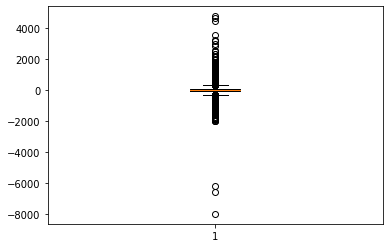

In [13]:
plt.boxplot(df_train['TARGET_WIN'])

In [14]:
df_valid.describe()

,CLOSE_1,VOL_1,BBANDS_Upper_5_1,BBANDS_Lower_5_1,BBANDS_Upper_10_1,BBANDS_Lower_10_1,BBANDS_Upper_20_1,BBANDS_Lower_20_1,DEMA_20_1,EMA_20_1,MIDPOINT_3_1,MIDPOINT_12_1,MIDPRICE_3_1,MIDPRICE_12_1,SAR_2_1,SAR_6_1,SAR_10_1,SAR_14_1,SAR_18_1,TEMA_5_1,TRIMA_5_1,TRIMA_10_1,TRIMA_20_1,WMA_5_1,WMA_10_1,WMA_20_1,ADX_3_1,ADX_6_1,ADX_10_1,APO_3_12_1,APO_5_12_1,BOP_1,CCI_3_1,CCI_6_1,CCI_12_1,CCI_20_1,MFI_3_1,MFI_6_1,MFI_12_1,MOM_3_1,MOM_6_1,MOM_10_1,MOM_14_1,PPO_3_12_1,PPO_12_20_1,ROC_3_1,ROC_5_1,ROC_7_1,ROC_10_1,RSI_3_1,RSI_6_1,RSI_10_1,RSI_14_1,TRIX_3_1,TRIX_5_1,TRIX_7_1,AD_1,ADOSC_1,OBV_1,ATR_3_1,ATR_6_1,ATR_12_1,ATR_20_1,TRANGE_1,MES_1,DIA_SEMANA_1,SEMANA_DO_ANO_1,CLOSE_2,VOL_2,BBANDS_Upper_5_2,BBANDS_Lower_5_2,BBANDS_Upper_10_2,BBANDS_Lower_10_2,BBANDS_Upper_20_2,BBANDS_Lower_20_2,DEMA_20_2,EMA_20_2,MIDPOINT_3_2,MIDPOINT_12_2,MIDPRICE_3_2,MIDPRICE_12_2,SAR_2_2,SAR_6_2,SAR_10_2,SAR_14_2,SAR_18_2,TEMA_5_2,TRIMA_5_2,TRIMA_10_2,TRIMA_20_2,WMA_5_2,WMA_10_2,WMA_20_2,ADX_3_2,ADX_6_2,ADX_10_2,APO_3_12_2,APO_5_12_2,BOP_2,CCI_3_2,CCI_6_2,CCI_12_2,CCI_20_2,MFI_3_2,MFI_6_2,MFI_12_2,MOM_3_2,MOM_6_2,MOM_10_2,MOM_14_2,PPO_3_12_2,PPO_12_20_2,ROC_3_2,ROC_5_2,ROC_7_2,ROC_10_2,RSI_3_2,RSI_6_2,RSI_10_2,RSI_14_2,TRIX_3_2,TRIX_5_2,TRIX_7_2,AD_2,ADOSC_2,OBV_2,ATR_3_2,ATR_6_2,ATR_12_2,ATR_20_2,TRANGE_2,MES_2,DIA_SEMANA_2,SEMANA_DO_ANO_2,CLOSE_3,VOL_3,BBANDS_Upper_5_3,BBANDS_Lower_5_3,BBANDS_Upper_10_3,BBANDS_Lower_10_3,BBANDS_Upper_20_3,BBANDS_Lower_20_3,DEMA_20_3,EMA_20_3,MIDPOINT_3_3,MIDPOINT_12_3,MIDPRICE_3_3,MIDPRICE_12_3,SAR_2_3,SAR_6_3,SAR_10_3,SAR_14_3,SAR_18_3,TEMA_5_3,TRIMA_5_3,TRIMA_10_3,TRIMA_20_3,WMA_5_3,WMA_10_3,WMA_20_3,ADX_3_3,ADX_6_3,ADX_10_3,APO_3_12_3,APO_5_12_3,BOP_3,CCI_3_3,CCI_6_3,CCI_12_3,CCI_20_3,MFI_3_3,MFI_6_3,MFI_12_3,MOM_3_3,MOM_6_3,MOM_10_3,MOM_14_3,PPO_3_12_3,PPO_12_20_3,ROC_3_3,ROC_5_3,ROC_7_3,ROC_10_3,RSI_3_3,RSI_6_3,RSI_10_3,RSI_14_3,TRIX_3_3,TRIX_5_3,TRIX_7_3,AD_3,ADOSC_3,OBV_3,ATR_3_3,ATR_6_3,ATR_12_3,ATR_20_3,TRANGE_3,MES_3,DIA_SEMANA_3,SEMANA_DO_ANO_3,CLOSE_4,VOL_4,BBANDS_Upper_5_4,BBANDS_Lower_5_4,BBANDS_Upper_10_4,BBANDS_Lower_10_4,BBANDS_Upper_20_4,BBANDS_Lower_20_4,DEMA_20_4,EMA_20_4,MIDPOINT_3_4,MIDPOINT_12_4,MIDPRICE_3_4,MIDPRICE_12_4,SAR_2_4,SAR_6_4,SAR_10_4,SAR_14_4,SAR_18_4,TEMA_5_4,TRIMA_5_4,TRIMA_10_4,TRIMA_20_4,WMA_5_4,WMA_10_4,WMA_20_4,ADX_3_4,ADX_6_4,ADX_10_4,APO_3_12_4,APO_5_12_4,BOP_4,CCI_3_4,CCI_6_4,CCI_12_4,CCI_20_4,MFI_3_4,MFI_6_4,MFI_12_4,MOM_3_4,MOM_6_4,MOM_10_4,MOM_14_4,PPO_3_12_4,PPO_12_20_4,ROC_3_4,ROC_5_4,ROC_7_4,ROC_10_4,RSI_3_4,RSI_6_4,RSI_10_4,RSI_14_4,TRIX_3_4,TRIX_5_4,TRIX_7_4,AD_4,ADOSC_4,OBV_4,ATR_3_4,ATR_6_4,ATR_12_4,ATR_20_4,TRANGE_4,MES_4,DIA_SEMANA_4,SEMANA_DO_ANO_4,CLOSE_5,VOL_5,BBANDS_Upper_5_5,BBANDS_Lower_5_5,BBANDS_Upper_10_5,BBANDS_Lower_10_5,BBANDS_Upper_20_5,BBANDS_Lower_20_5,DEMA_20_5,EMA_20_5,MIDPOINT_3_5,MIDPOINT_12_5,MIDPRICE_3_5,MIDPRICE_12_5,SAR_2_5,SAR_6_5,SAR_10_5,SAR_14_5,SAR_18_5,TEMA_5_5,TRIMA_5_5,TRIMA_10_5,TRIMA_20_5,WMA_5_5,WMA_10_5,WMA_20_5,ADX_3_5,ADX_6_5,ADX_10_5,APO_3_12_5,APO_5_12_5,BOP_5,CCI_3_5,CCI_6_5,CCI_12_5,CCI_20_5,MFI_3_5,MFI_6_5,MFI_12_5,MOM_3_5,MOM_6_5,MOM_10_5,MOM_14_5,PPO_3_12_5,PPO_12_20_5,ROC_3_5,ROC_5_5,ROC_7_5,ROC_10_5,RSI_3_5,RSI_6_5,RSI_10_5,RSI_14_5,TRIX_3_5,TRIX_5_5,TRIX_7_5,AD_5,ADOSC_5,OBV_5,ATR_3_5,ATR_6_5,ATR_12_5,ATR_20_5,TRANGE_5,MES_5,DIA_SEMANA_5,SEMANA_DO_ANO_5,CLOSE_6,VOL_6,BBANDS_Upper_5_6,BBANDS_Lower_5_6,BBANDS_Upper_10_6,BBANDS_Lower_10_6,BBANDS_Upper_20_6,BBANDS_Lower_20_6,DEMA_20_6,EMA_20_6,MIDPOINT_3_6,MIDPOINT_12_6,MIDPRICE_3_6,MIDPRICE_12_6,SAR_2_6,SAR_6_6,SAR_10_6,SAR_14_6,SAR_18_6,TEMA_5_6,TRIMA_5_6,TRIMA_10_6,TRIMA_20_6,WMA_5_6,WMA_10_6,WMA_20_6,ADX_3_6,ADX_6_6,ADX_10_6,APO_3_12_6,APO_5_12_6,BOP_6,CCI_3_6,CCI_6_6,CCI_12_6,CCI_20_6,MFI_3_6,MFI_6_6,MFI_12_6,MOM_3_6,MOM_6_6,MOM_10_6,MOM_14_6,PPO_3_12_6,PPO_12_20_6,ROC_3_6,ROC_5_6,ROC_7_6,ROC_10_6,RSI_3_6,RSI_6_6,RSI_10_6,RSI_14_6,TRIX_3_6,TRIX_5_6,TRIX_7_6,AD_6,ADOSC_6,OBV_6,ATR_3_6,ATR_6_6,ATR_12_6,ATR_20_6,TRANGE_6,MES_6,DIA_SEMANA_6,SEMANA_DO_ANO_6,CLOSE_7,VOL_7,BBANDS_

{'whiskers': [<matplotlib.lines.Line2D at 0x23a00372b38>,
 'caps': [<matplotlib.lines.Line2D at 0x23a00367b70>,
 'boxes': [<matplotlib.lines.Line2D at 0x23a00372b00>],
 'medians': [<matplotlib.lines.Line2D at 0x23a00367320>],
 'fliers': [<matplotlib.lines.Line2D at 0x23a0035fcf8>],
 'means': []}

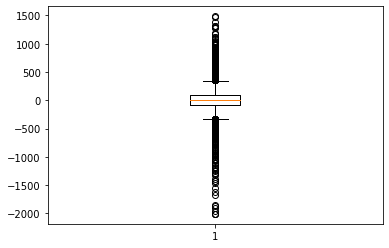

In [15]:
plt.boxplot(df_valid['TARGET_WIN'])

In [16]:
df_test.describe()

,CLOSE_1,VOL_1,BBANDS_Upper_5_1,BBANDS_Lower_5_1,BBANDS_Upper_10_1,BBANDS_Lower_10_1,BBANDS_Upper_20_1,BBANDS_Lower_20_1,DEMA_20_1,EMA_20_1,MIDPOINT_3_1,MIDPOINT_12_1,MIDPRICE_3_1,MIDPRICE_12_1,SAR_2_1,SAR_6_1,SAR_10_1,SAR_14_1,SAR_18_1,TEMA_5_1,TRIMA_5_1,TRIMA_10_1,TRIMA_20_1,WMA_5_1,WMA_10_1,WMA_20_1,ADX_3_1,ADX_6_1,ADX_10_1,APO_3_12_1,APO_5_12_1,BOP_1,CCI_3_1,CCI_6_1,CCI_12_1,CCI_20_1,MFI_3_1,MFI_6_1,MFI_12_1,MOM_3_1,MOM_6_1,MOM_10_1,MOM_14_1,PPO_3_12_1,PPO_12_20_1,ROC_3_1,ROC_5_1,ROC_7_1,ROC_10_1,RSI_3_1,RSI_6_1,RSI_10_1,RSI_14_1,TRIX_3_1,TRIX_5_1,TRIX_7_1,AD_1,ADOSC_1,OBV_1,ATR_3_1,ATR_6_1,ATR_12_1,ATR_20_1,TRANGE_1,MES_1,DIA_SEMANA_1,SEMANA_DO_ANO_1,CLOSE_2,VOL_2,BBANDS_Upper_5_2,BBANDS_Lower_5_2,BBANDS_Upper_10_2,BBANDS_Lower_10_2,BBANDS_Upper_20_2,BBANDS_Lower_20_2,DEMA_20_2,EMA_20_2,MIDPOINT_3_2,MIDPOINT_12_2,MIDPRICE_3_2,MIDPRICE_12_2,SAR_2_2,SAR_6_2,SAR_10_2,SAR_14_2,SAR_18_2,TEMA_5_2,TRIMA_5_2,TRIMA_10_2,TRIMA_20_2,WMA_5_2,WMA_10_2,WMA_20_2,ADX_3_2,ADX_6_2,ADX_10_2,APO_3_12_2,APO_5_12_2,BOP_2,CCI_3_2,CCI_6_2,CCI_12_2,CCI_20_2,MFI_3_2,MFI_6_2,MFI_12_2,MOM_3_2,MOM_6_2,MOM_10_2,MOM_14_2,PPO_3_12_2,PPO_12_20_2,ROC_3_2,ROC_5_2,ROC_7_2,ROC_10_2,RSI_3_2,RSI_6_2,RSI_10_2,RSI_14_2,TRIX_3_2,TRIX_5_2,TRIX_7_2,AD_2,ADOSC_2,OBV_2,ATR_3_2,ATR_6_2,ATR_12_2,ATR_20_2,TRANGE_2,MES_2,DIA_SEMANA_2,SEMANA_DO_ANO_2,CLOSE_3,VOL_3,BBANDS_Upper_5_3,BBANDS_Lower_5_3,BBANDS_Upper_10_3,BBANDS_Lower_10_3,BBANDS_Upper_20_3,BBANDS_Lower_20_3,DEMA_20_3,EMA_20_3,MIDPOINT_3_3,MIDPOINT_12_3,MIDPRICE_3_3,MIDPRICE_12_3,SAR_2_3,SAR_6_3,SAR_10_3,SAR_14_3,SAR_18_3,TEMA_5_3,TRIMA_5_3,TRIMA_10_3,TRIMA_20_3,WMA_5_3,WMA_10_3,WMA_20_3,ADX_3_3,ADX_6_3,ADX_10_3,APO_3_12_3,APO_5_12_3,BOP_3,CCI_3_3,CCI_6_3,CCI_12_3,CCI_20_3,MFI_3_3,MFI_6_3,MFI_12_3,MOM_3_3,MOM_6_3,MOM_10_3,MOM_14_3,PPO_3_12_3,PPO_12_20_3,ROC_3_3,ROC_5_3,ROC_7_3,ROC_10_3,RSI_3_3,RSI_6_3,RSI_10_3,RSI_14_3,TRIX_3_3,TRIX_5_3,TRIX_7_3,AD_3,ADOSC_3,OBV_3,ATR_3_3,ATR_6_3,ATR_12_3,ATR_20_3,TRANGE_3,MES_3,DIA_SEMANA_3,SEMANA_DO_ANO_3,CLOSE_4,VOL_4,BBANDS_Upper_5_4,BBANDS_Lower_5_4,BBANDS_Upper_10_4,BBANDS_Lower_10_4,BBANDS_Upper_20_4,BBANDS_Lower_20_4,DEMA_20_4,EMA_20_4,MIDPOINT_3_4,MIDPOINT_12_4,MIDPRICE_3_4,MIDPRICE_12_4,SAR_2_4,SAR_6_4,SAR_10_4,SAR_14_4,SAR_18_4,TEMA_5_4,TRIMA_5_4,TRIMA_10_4,TRIMA_20_4,WMA_5_4,WMA_10_4,WMA_20_4,ADX_3_4,ADX_6_4,ADX_10_4,APO_3_12_4,APO_5_12_4,BOP_4,CCI_3_4,CCI_6_4,CCI_12_4,CCI_20_4,MFI_3_4,MFI_6_4,MFI_12_4,MOM_3_4,MOM_6_4,MOM_10_4,MOM_14_4,PPO_3_12_4,PPO_12_20_4,ROC_3_4,ROC_5_4,ROC_7_4,ROC_10_4,RSI_3_4,RSI_6_4,RSI_10_4,RSI_14_4,TRIX_3_4,TRIX_5_4,TRIX_7_4,AD_4,ADOSC_4,OBV_4,ATR_3_4,ATR_6_4,ATR_12_4,ATR_20_4,TRANGE_4,MES_4,DIA_SEMANA_4,SEMANA_DO_ANO_4,CLOSE_5,VOL_5,BBANDS_Upper_5_5,BBANDS_Lower_5_5,BBANDS_Upper_10_5,BBANDS_Lower_10_5,BBANDS_Upper_20_5,BBANDS_Lower_20_5,DEMA_20_5,EMA_20_5,MIDPOINT_3_5,MIDPOINT_12_5,MIDPRICE_3_5,MIDPRICE_12_5,SAR_2_5,SAR_6_5,SAR_10_5,SAR_14_5,SAR_18_5,TEMA_5_5,TRIMA_5_5,TRIMA_10_5,TRIMA_20_5,WMA_5_5,WMA_10_5,WMA_20_5,ADX_3_5,ADX_6_5,ADX_10_5,APO_3_12_5,APO_5_12_5,BOP_5,CCI_3_5,CCI_6_5,CCI_12_5,CCI_20_5,MFI_3_5,MFI_6_5,MFI_12_5,MOM_3_5,MOM_6_5,MOM_10_5,MOM_14_5,PPO_3_12_5,PPO_12_20_5,ROC_3_5,ROC_5_5,ROC_7_5,ROC_10_5,RSI_3_5,RSI_6_5,RSI_10_5,RSI_14_5,TRIX_3_5,TRIX_5_5,TRIX_7_5,AD_5,ADOSC_5,OBV_5,ATR_3_5,ATR_6_5,ATR_12_5,ATR_20_5,TRANGE_5,MES_5,DIA_SEMANA_5,SEMANA_DO_ANO_5,CLOSE_6,VOL_6,BBANDS_Upper_5_6,BBANDS_Lower_5_6,BBANDS_Upper_10_6,BBANDS_Lower_10_6,BBANDS_Upper_20_6,BBANDS_Lower_20_6,DEMA_20_6,EMA_20_6,MIDPOINT_3_6,MIDPOINT_12_6,MIDPRICE_3_6,MIDPRICE_12_6,SAR_2_6,SAR_6_6,SAR_10_6,SAR_14_6,SAR_18_6,TEMA_5_6,TRIMA_5_6,TRIMA_10_6,TRIMA_20_6,WMA_5_6,WMA_10_6,WMA_20_6,ADX_3_6,ADX_6_6,ADX_10_6,APO_3_12_6,APO_5_12_6,BOP_6,CCI_3_6,CCI_6_6,CCI_12_6,CCI_20_6,MFI_3_6,MFI_6_6,MFI_12_6,MOM_3_6,MOM_6_6,MOM_10_6,MOM_14_6,PPO_3_12_6,PPO_12_20_6,ROC_3_6,ROC_5_6,ROC_7_6,ROC_10_6,RSI_3_6,RSI_6_6,RSI_10_6,RSI_14_6,TRIX_3_6,TRIX_5_6,TRIX_7_6,AD_6,ADOSC_6,OBV_6,ATR_3_6,ATR_6_6,ATR_12_6,ATR_20_6,TRANGE_6,MES_6,DIA_SEMANA_6,SEMANA_DO_ANO_6,CLOSE_7,VOL_7,BBANDS_

{'whiskers': [<matplotlib.lines.Line2D at 0x23a00405b70>,
 'caps': [<matplotlib.lines.Line2D at 0x23a003fd828>,
 'boxes': [<matplotlib.lines.Line2D at 0x23a00405c18>],
 'medians': [<matplotlib.lines.Line2D at 0x23a003fdac8>],
 'fliers': [<matplotlib.lines.Line2D at 0x23a003f74a8>],
 'means': []}

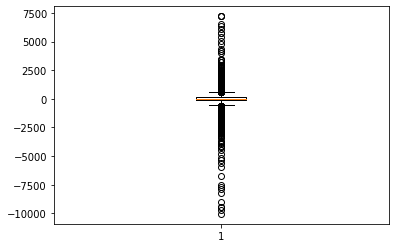

In [17]:
plt.boxplot(df_test['TARGET_WIN'])

# Data Scaling

1º Ciclo: Normalizar todos os dados de cada split

2º Ciclo: Normalizar a cada slide window


In [18]:
std_scaler_train = StandardScaler()
train_ss = std_scaler_train.fit_transform(df_train)

In [19]:
df_train_ss = pd.DataFrame(train_ss)
df_train_ss.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603
0,-1.832191,-0.792263,-1.838765,-1.840448,-1.843605,-1.842774,-1.843419,-1.838923,-1.840696,-1.838057,-1.838412,-1.841518,-1.838995,-1.842049,-1.849245,-1.847508,-1.847615,-1.847634,-1.847666,-1.835289,-1.840437,-1.842920,-1.844669,-1.838813,-1.840997,-1.842854,0.435261,0.192210,0.305460,0.430154,0.536102,1.500596,1.055860,1.191038,1.257080,0.527594,-0.084385,0.921349,0.379029,0.426852,0.621762,0.739691,0.426941,0.595503,-0.471684,0.590477,0.770646,1.269405,1.026637,1.100905,0.991697,0.569644,0.192565,0.694544,0.461561,-0.068784,-0.226987,0.090440,0.579312,-0.073163,-0.373711,-0.576414,-0.663328,0.965125,1.769491,0.709607,1.796714,-0.603728,-0.795160,-0.599285,-0.595054,-0.604234,-0.595154,-0.594291,-0.590293,-0.600690,-0.592963,-0.599082,-0.600573,-0.598360,-0.599172,-0.608937,-0.591429,-0.591407,-0.591402,-0.591395,-0.601507,-0.596470,-0.598197,-0.594375,-0.598757,-0.598600,-0.596348,-0.198065,-1.042466,-1.267418,0.000981,0.205393,-0.985989,-1.246666,-1.503118,-0.571909,-0.786449,-1.466198,-0.898416,-1.075547,-0.698123,-0.334237,-0.195032,-0.622019,0.001205,-0.841857,-0.762191,-0.204645,-0.256834,-0.213935,-1.299206,-0.891561,-0.672712,-0.711765,-0.309354,-0.192980,-0.405278,1.509008,-0.269707,-0.781458,-0.646104,-0.731636,-0.716673,-0.741941,-0.301249,1.769491,0.709607,1.796714,-1.785468,-0.288120,-1.781146,-1.781079,-1.794621,-1.783748,-1.805643,-1.767461,-1.786966,-1.778549,-1.782926,-1.785521,-1.777810,-1.785871,-1.803587,-1.759213,-1.759164,-1.759151,-1.759072,-1.784333,-1.779158,-1.788223,-1.791566,-1.782440,-1.785765,-1.788766,-0.925812,-0.754830,-0.227316,0.325099,0.562645,0.460857,-0.744018,-0.297012,0.399793,0.075311,0.158610,0.676240,0.262423,-0.804639

In [20]:
df_train_ss.columns = df_train.columns
df_train_ss.head(3)

,CLOSE_1,VOL_1,BBANDS_Upper_5_1,BBANDS_Lower_5_1,BBANDS_Upper_10_1,BBANDS_Lower_10_1,BBANDS_Upper_20_1,BBANDS_Lower_20_1,DEMA_20_1,EMA_20_1,MIDPOINT_3_1,MIDPOINT_12_1,MIDPRICE_3_1,MIDPRICE_12_1,SAR_2_1,SAR_6_1,SAR_10_1,SAR_14_1,SAR_18_1,TEMA_5_1,TRIMA_5_1,TRIMA_10_1,TRIMA_20_1,WMA_5_1,WMA_10_1,WMA_20_1,ADX_3_1,ADX_6_1,ADX_10_1,APO_3_12_1,APO_5_12_1,BOP_1,CCI_3_1,CCI_6_1,CCI_12_1,CCI_20_1,MFI_3_1,MFI_6_1,MFI_12_1,MOM_3_1,MOM_6_1,MOM_10_1,MOM_14_1,PPO_3_12_1,PPO_12_20_1,ROC_3_1,ROC_5_1,ROC_7_1,ROC_10_1,RSI_3_1,RSI_6_1,RSI_10_1,RSI_14_1,TRIX_3_1,TRIX_5_1,TRIX_7_1,AD_1,ADOSC_1,OBV_1,ATR_3_1,ATR_6_1,ATR_12_1,ATR_20_1,TRANGE_1,MES_1,DIA_SEMANA_1,SEMANA_DO_ANO_1,CLOSE_2,VOL_2,BBANDS_Upper_5_2,BBANDS_Lower_5_2,BBANDS_Upper_10_2,BBANDS_Lower_10_2,BBANDS_Upper_20_2,BBANDS_Lower_20_2,DEMA_20_2,EMA_20_2,MIDPOINT_3_2,MIDPOINT_12_2,MIDPRICE_3_2,MIDPRICE_12_2,SAR_2_2,SAR_6_2,SAR_10_2,SAR_14_2,SAR_18_2,TEMA_5_2,TRIMA_5_2,TRIMA_10_2,TRIMA_20_2,WMA_5_2,WMA_10_2,WMA_20_2,ADX_3_2,ADX_6_2,ADX_10_2,APO_3_12_2,APO_5_12_2,BOP_2,CCI_3_2,CCI_6_2,CCI_12_2,CCI_20_2,MFI_3_2,MFI_6_2,MFI_12_2,MOM_3_2,MOM_6_2,MOM_10_2,MOM_14_2,PPO_3_12_2,PPO_12_20_2,ROC_3_2,ROC_5_2,ROC_7_2,ROC_10_2,RSI_3_2,RSI_6_2,RSI_10_2,RSI_14_2,TRIX_3_2,TRIX_5_2,TRIX_7_2,AD_2,ADOSC_2,OBV_2,ATR_3_2,ATR_6_2,ATR_12_2,ATR_20_2,TRANGE_2,MES_2,DIA_SEMANA_2,SEMANA_DO_ANO_2,CLOSE_3,VOL_3,BBANDS_Upper_5_3,BBANDS_Lower_5_3,BBANDS_Upper_10_3,BBANDS_Lower_10_3,BBANDS_Upper_20_3,BBANDS_Lower_20_3,DEMA_20_3,EMA_20_3,MIDPOINT_3_3,MIDPOINT_12_3,MIDPRICE_3_3,MIDPRICE_12_3,SAR_2_3,SAR_6_3,SAR_10_3,SAR_14_3,SAR_18_3,TEMA_5_3,TRIMA_5_3,TRIMA_10_3,TRIMA_20_3,WMA_5_3,WMA_10_3,WMA_20_3,ADX_3_3,ADX_6_3,ADX_10_3,APO_3_12_3,APO_5_12_3,BOP_3,CCI_3_3,CCI_6_3,CCI_12_3,CCI_20_3,MFI_3_3,MFI_6_3,MFI_12_3,MOM_3_3,MOM_6_3,MOM_10_3,MOM_14_3,PPO_3_12_3,PPO_12_20_3,ROC_3_3,ROC_5_3,ROC_7_3,ROC_10_3,RSI_3_3,RSI_6_3,RSI_10_3,RSI_14_3,TRIX_3_3,TRIX_5_3,TRIX_7_3,AD_3,ADOSC_3,OBV_3,ATR_3_3,ATR_6_3,ATR_12_3,ATR_20_3,TRANGE_3,MES_3,DIA_SEMANA_3,SEMANA_DO_ANO_3,CLOSE_4,VOL_4,BBANDS_Upper_5_4,BBANDS_Lower_5_4,BBANDS_Upper_10_4,BBANDS_Lower_10_4,BBANDS_Upper_20_4,BBANDS_Lower_20_4,DEMA_20_4,EMA_20_4,MIDPOINT_3_4,MIDPOINT_12_4,MIDPRICE_3_4,MIDPRICE_12_4,SAR_2_4,SAR_6_4,SAR_10_4,SAR_14_4,SAR_18_4,TEMA_5_4,TRIMA_5_4,TRIMA_10_4,TRIMA_20_4,WMA_5_4,WMA_10_4,WMA_20_4,ADX_3_4,ADX_6_4,ADX_10_4,APO_3_12_4,APO_5_12_4,BOP_4,CCI_3_4,CCI_6_4,CCI_12_4,CCI_20_4,MFI_3_4,MFI_6_4,MFI_12_4,MOM_3_4,MOM_6_4,MOM_10_4,MOM_14_4,PPO_3_12_4,PPO_12_20_4,ROC_3_4,ROC_5_4,ROC_7_4,ROC_10_4,RSI_3_4,RSI_6_4,RSI_10_4,RSI_14_4,TRIX_3_4,TRIX_5_4,TRIX_7_4,AD_4,ADOSC_4,OBV_4,ATR_3_4,ATR_6_4,ATR_12_4,ATR_20_4,TRANGE_4,MES_4,DIA_SEMANA_4,SEMANA_DO_ANO_4,CLOSE_5,VOL_5,BBANDS_Upper_5_5,BBANDS_Lower_5_5,BBANDS_Upper_10_5,BBANDS_Lower_10_5,BBANDS_Upper_20_5,BBANDS_Lower_20_5,DEMA_20_5,EMA_20_5,MIDPOINT_3_5,MIDPOINT_12_5,MIDPRICE_3_5,MIDPRICE_12_5,SAR_2_5,SAR_6_5,SAR_10_5,SAR_14_5,SAR_18_5,TEMA_5_5,TRIMA_5_5,TRIMA_10_5,TRIMA_20_5,WMA_5_5,WMA_10_5,WMA_20_5,ADX_3_5,ADX_6_5,ADX_10_5,APO_3_12_5,APO_5_12_5,BOP_5,CCI_3_5,CCI_6_5,CCI_12_5,CCI_20_5,MFI_3_5,MFI_6_5,MFI_12_5,MOM_3_5,MOM_6_5,MOM_10_5,MOM_14_5,PPO_3_12_5,PPO_12_20_5,ROC_3_5,ROC_5_5,ROC_7_5,ROC_10_5,RSI_3_5,RSI_6_5,RSI_10_5,RSI_14_5,TRIX_3_5,TRIX_5_5,TRIX_7_5,AD_5,ADOSC_5,OBV_5,ATR_3_5,ATR_6_5,ATR_12_5,ATR_20_5,TRANGE_5,MES_5,DIA_SEMANA_5,SEMANA_DO_ANO_5,CLOSE_6,VOL_6,BBANDS_Upper_5_6,BBANDS_Lower_5_6,BBANDS_Upper_10_6,BBANDS_Lower_10_6,BBANDS_Upper_20_6,BBANDS_Lower_20_6,DEMA_20_6,EMA_20_6,MIDPOINT_3_6,MIDPOINT_12_6,MIDPRICE_3_6,MIDPRICE_12_6,SAR_2_6,SAR_6_6,SAR_10_6,SAR_14_6,SAR_18_6,TEMA_5_6,TRIMA_5_6,TRIMA_10_6,TRIMA_20_6,WMA_5_6,WMA_10_6,WMA_20_6,ADX_3_6,ADX_6_6,ADX_10_6,APO_3_12_6,APO_5_12_6,BOP_6,CCI_3_6,CCI_6_6,CCI_12_6,CCI_20_6,MFI_3_6,MFI_6_6,MFI_12_6,MOM_3_6,MOM_6_6,MOM_10_6,MOM_14_6,PPO_3_12_6,PPO_12_20_6,ROC_3_6,ROC_5_6,ROC_7_6,ROC_10_6,RSI_3_6,RSI_6_6,RSI_10_6,RSI_14_6,TRIX_3_6,TRIX_5_6,TRIX_7_6,AD_6,ADOSC_6,OBV_6,ATR_3_6,ATR_6_6,ATR_12_6,ATR_20_6,TRANGE_6,MES_6,DIA_SEMANA_6,SEMANA_DO_ANO_6,CLOSE_7,VOL_7,BBANDS_

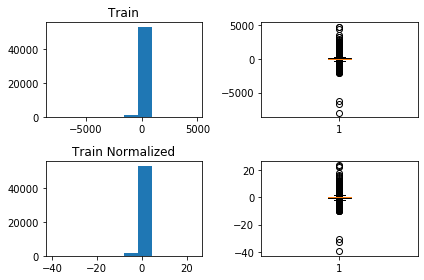

In [21]:
plt.figure(1)

plt.subplot(2,2,1)
plt.hist(df_train['TARGET_WIN'])
plt.title('Train')
plt.subplot(2,2,2)
plt.boxplot(df_train['TARGET_WIN'])

plt.subplot(2,2,3)
plt.hist(df_train_ss['TARGET_WIN'])
plt.title('Train Normalized')
plt.subplot(2,2,4)
plt.boxplot(df_train_ss['TARGET_WIN'])

plt.tight_layout()

In [22]:
std_scaler_valid = StandardScaler()
valid_ss = std_scaler_valid.fit_transform(df_valid)
df_valid_ss = pd.DataFrame(valid_ss)
df_valid_ss.columns = df_valid.columns
df_valid_ss.head(3)

,CLOSE_1,VOL_1,BBANDS_Upper_5_1,BBANDS_Lower_5_1,BBANDS_Upper_10_1,BBANDS_Lower_10_1,BBANDS_Upper_20_1,BBANDS_Lower_20_1,DEMA_20_1,EMA_20_1,MIDPOINT_3_1,MIDPOINT_12_1,MIDPRICE_3_1,MIDPRICE_12_1,SAR_2_1,SAR_6_1,SAR_10_1,SAR_14_1,SAR_18_1,TEMA_5_1,TRIMA_5_1,TRIMA_10_1,TRIMA_20_1,WMA_5_1,WMA_10_1,WMA_20_1,ADX_3_1,ADX_6_1,ADX_10_1,APO_3_12_1,APO_5_12_1,BOP_1,CCI_3_1,CCI_6_1,CCI_12_1,CCI_20_1,MFI_3_1,MFI_6_1,MFI_12_1,MOM_3_1,MOM_6_1,MOM_10_1,MOM_14_1,PPO_3_12_1,PPO_12_20_1,ROC_3_1,ROC_5_1,ROC_7_1,ROC_10_1,RSI_3_1,RSI_6_1,RSI_10_1,RSI_14_1,TRIX_3_1,TRIX_5_1,TRIX_7_1,AD_1,ADOSC_1,OBV_1,ATR_3_1,ATR_6_1,ATR_12_1,ATR_20_1,TRANGE_1,MES_1,DIA_SEMANA_1,SEMANA_DO_ANO_1,CLOSE_2,VOL_2,BBANDS_Upper_5_2,BBANDS_Lower_5_2,BBANDS_Upper_10_2,BBANDS_Lower_10_2,BBANDS_Upper_20_2,BBANDS_Lower_20_2,DEMA_20_2,EMA_20_2,MIDPOINT_3_2,MIDPOINT_12_2,MIDPRICE_3_2,MIDPRICE_12_2,SAR_2_2,SAR_6_2,SAR_10_2,SAR_14_2,SAR_18_2,TEMA_5_2,TRIMA_5_2,TRIMA_10_2,TRIMA_20_2,WMA_5_2,WMA_10_2,WMA_20_2,ADX_3_2,ADX_6_2,ADX_10_2,APO_3_12_2,APO_5_12_2,BOP_2,CCI_3_2,CCI_6_2,CCI_12_2,CCI_20_2,MFI_3_2,MFI_6_2,MFI_12_2,MOM_3_2,MOM_6_2,MOM_10_2,MOM_14_2,PPO_3_12_2,PPO_12_20_2,ROC_3_2,ROC_5_2,ROC_7_2,ROC_10_2,RSI_3_2,RSI_6_2,RSI_10_2,RSI_14_2,TRIX_3_2,TRIX_5_2,TRIX_7_2,AD_2,ADOSC_2,OBV_2,ATR_3_2,ATR_6_2,ATR_12_2,ATR_20_2,TRANGE_2,MES_2,DIA_SEMANA_2,SEMANA_DO_ANO_2,CLOSE_3,VOL_3,BBANDS_Upper_5_3,BBANDS_Lower_5_3,BBANDS_Upper_10_3,BBANDS_Lower_10_3,BBANDS_Upper_20_3,BBANDS_Lower_20_3,DEMA_20_3,EMA_20_3,MIDPOINT_3_3,MIDPOINT_12_3,MIDPRICE_3_3,MIDPRICE_12_3,SAR_2_3,SAR_6_3,SAR_10_3,SAR_14_3,SAR_18_3,TEMA_5_3,TRIMA_5_3,TRIMA_10_3,TRIMA_20_3,WMA_5_3,WMA_10_3,WMA_20_3,ADX_3_3,ADX_6_3,ADX_10_3,APO_3_12_3,APO_5_12_3,BOP_3,CCI_3_3,CCI_6_3,CCI_12_3,CCI_20_3,MFI_3_3,MFI_6_3,MFI_12_3,MOM_3_3,MOM_6_3,MOM_10_3,MOM_14_3,PPO_3_12_3,PPO_12_20_3,ROC_3_3,ROC_5_3,ROC_7_3,ROC_10_3,RSI_3_3,RSI_6_3,RSI_10_3,RSI_14_3,TRIX_3_3,TRIX_5_3,TRIX_7_3,AD_3,ADOSC_3,OBV_3,ATR_3_3,ATR_6_3,ATR_12_3,ATR_20_3,TRANGE_3,MES_3,DIA_SEMANA_3,SEMANA_DO_ANO_3,CLOSE_4,VOL_4,BBANDS_Upper_5_4,BBANDS_Lower_5_4,BBANDS_Upper_10_4,BBANDS_Lower_10_4,BBANDS_Upper_20_4,BBANDS_Lower_20_4,DEMA_20_4,EMA_20_4,MIDPOINT_3_4,MIDPOINT_12_4,MIDPRICE_3_4,MIDPRICE_12_4,SAR_2_4,SAR_6_4,SAR_10_4,SAR_14_4,SAR_18_4,TEMA_5_4,TRIMA_5_4,TRIMA_10_4,TRIMA_20_4,WMA_5_4,WMA_10_4,WMA_20_4,ADX_3_4,ADX_6_4,ADX_10_4,APO_3_12_4,APO_5_12_4,BOP_4,CCI_3_4,CCI_6_4,CCI_12_4,CCI_20_4,MFI_3_4,MFI_6_4,MFI_12_4,MOM_3_4,MOM_6_4,MOM_10_4,MOM_14_4,PPO_3_12_4,PPO_12_20_4,ROC_3_4,ROC_5_4,ROC_7_4,ROC_10_4,RSI_3_4,RSI_6_4,RSI_10_4,RSI_14_4,TRIX_3_4,TRIX_5_4,TRIX_7_4,AD_4,ADOSC_4,OBV_4,ATR_3_4,ATR_6_4,ATR_12_4,ATR_20_4,TRANGE_4,MES_4,DIA_SEMANA_4,SEMANA_DO_ANO_4,CLOSE_5,VOL_5,BBANDS_Upper_5_5,BBANDS_Lower_5_5,BBANDS_Upper_10_5,BBANDS_Lower_10_5,BBANDS_Upper_20_5,BBANDS_Lower_20_5,DEMA_20_5,EMA_20_5,MIDPOINT_3_5,MIDPOINT_12_5,MIDPRICE_3_5,MIDPRICE_12_5,SAR_2_5,SAR_6_5,SAR_10_5,SAR_14_5,SAR_18_5,TEMA_5_5,TRIMA_5_5,TRIMA_10_5,TRIMA_20_5,WMA_5_5,WMA_10_5,WMA_20_5,ADX_3_5,ADX_6_5,ADX_10_5,APO_3_12_5,APO_5_12_5,BOP_5,CCI_3_5,CCI_6_5,CCI_12_5,CCI_20_5,MFI_3_5,MFI_6_5,MFI_12_5,MOM_3_5,MOM_6_5,MOM_10_5,MOM_14_5,PPO_3_12_5,PPO_12_20_5,ROC_3_5,ROC_5_5,ROC_7_5,ROC_10_5,RSI_3_5,RSI_6_5,RSI_10_5,RSI_14_5,TRIX_3_5,TRIX_5_5,TRIX_7_5,AD_5,ADOSC_5,OBV_5,ATR_3_5,ATR_6_5,ATR_12_5,ATR_20_5,TRANGE_5,MES_5,DIA_SEMANA_5,SEMANA_DO_ANO_5,CLOSE_6,VOL_6,BBANDS_Upper_5_6,BBANDS_Lower_5_6,BBANDS_Upper_10_6,BBANDS_Lower_10_6,BBANDS_Upper_20_6,BBANDS_Lower_20_6,DEMA_20_6,EMA_20_6,MIDPOINT_3_6,MIDPOINT_12_6,MIDPRICE_3_6,MIDPRICE_12_6,SAR_2_6,SAR_6_6,SAR_10_6,SAR_14_6,SAR_18_6,TEMA_5_6,TRIMA_5_6,TRIMA_10_6,TRIMA_20_6,WMA_5_6,WMA_10_6,WMA_20_6,ADX_3_6,ADX_6_6,ADX_10_6,APO_3_12_6,APO_5_12_6,BOP_6,CCI_3_6,CCI_6_6,CCI_12_6,CCI_20_6,MFI_3_6,MFI_6_6,MFI_12_6,MOM_3_6,MOM_6_6,MOM_10_6,MOM_14_6,PPO_3_12_6,PPO_12_20_6,ROC_3_6,ROC_5_6,ROC_7_6,ROC_10_6,RSI_3_6,RSI_6_6,RSI_10_6,RSI_14_6,TRIX_3_6,TRIX_5_6,TRIX_7_6,AD_6,ADOSC_6,OBV_6,ATR_3_6,ATR_6_6,ATR_12_6,ATR_20_6,TRANGE_6,MES_6,DIA_SEMANA_6,SEMANA_DO_ANO_6,CLOSE_7,VOL_7,BBANDS_

In [23]:
std_scaler_test = StandardScaler()
test_ss = std_scaler_test.fit_transform(df_test)
df_test_ss = pd.DataFrame(test_ss)
df_test_ss.columns = df_test.columns
df_test_ss.head(3)

,CLOSE_1,VOL_1,BBANDS_Upper_5_1,BBANDS_Lower_5_1,BBANDS_Upper_10_1,BBANDS_Lower_10_1,BBANDS_Upper_20_1,BBANDS_Lower_20_1,DEMA_20_1,EMA_20_1,MIDPOINT_3_1,MIDPOINT_12_1,MIDPRICE_3_1,MIDPRICE_12_1,SAR_2_1,SAR_6_1,SAR_10_1,SAR_14_1,SAR_18_1,TEMA_5_1,TRIMA_5_1,TRIMA_10_1,TRIMA_20_1,WMA_5_1,WMA_10_1,WMA_20_1,ADX_3_1,ADX_6_1,ADX_10_1,APO_3_12_1,APO_5_12_1,BOP_1,CCI_3_1,CCI_6_1,CCI_12_1,CCI_20_1,MFI_3_1,MFI_6_1,MFI_12_1,MOM_3_1,MOM_6_1,MOM_10_1,MOM_14_1,PPO_3_12_1,PPO_12_20_1,ROC_3_1,ROC_5_1,ROC_7_1,ROC_10_1,RSI_3_1,RSI_6_1,RSI_10_1,RSI_14_1,TRIX_3_1,TRIX_5_1,TRIX_7_1,AD_1,ADOSC_1,OBV_1,ATR_3_1,ATR_6_1,ATR_12_1,ATR_20_1,TRANGE_1,MES_1,DIA_SEMANA_1,SEMANA_DO_ANO_1,CLOSE_2,VOL_2,BBANDS_Upper_5_2,BBANDS_Lower_5_2,BBANDS_Upper_10_2,BBANDS_Lower_10_2,BBANDS_Upper_20_2,BBANDS_Lower_20_2,DEMA_20_2,EMA_20_2,MIDPOINT_3_2,MIDPOINT_12_2,MIDPRICE_3_2,MIDPRICE_12_2,SAR_2_2,SAR_6_2,SAR_10_2,SAR_14_2,SAR_18_2,TEMA_5_2,TRIMA_5_2,TRIMA_10_2,TRIMA_20_2,WMA_5_2,WMA_10_2,WMA_20_2,ADX_3_2,ADX_6_2,ADX_10_2,APO_3_12_2,APO_5_12_2,BOP_2,CCI_3_2,CCI_6_2,CCI_12_2,CCI_20_2,MFI_3_2,MFI_6_2,MFI_12_2,MOM_3_2,MOM_6_2,MOM_10_2,MOM_14_2,PPO_3_12_2,PPO_12_20_2,ROC_3_2,ROC_5_2,ROC_7_2,ROC_10_2,RSI_3_2,RSI_6_2,RSI_10_2,RSI_14_2,TRIX_3_2,TRIX_5_2,TRIX_7_2,AD_2,ADOSC_2,OBV_2,ATR_3_2,ATR_6_2,ATR_12_2,ATR_20_2,TRANGE_2,MES_2,DIA_SEMANA_2,SEMANA_DO_ANO_2,CLOSE_3,VOL_3,BBANDS_Upper_5_3,BBANDS_Lower_5_3,BBANDS_Upper_10_3,BBANDS_Lower_10_3,BBANDS_Upper_20_3,BBANDS_Lower_20_3,DEMA_20_3,EMA_20_3,MIDPOINT_3_3,MIDPOINT_12_3,MIDPRICE_3_3,MIDPRICE_12_3,SAR_2_3,SAR_6_3,SAR_10_3,SAR_14_3,SAR_18_3,TEMA_5_3,TRIMA_5_3,TRIMA_10_3,TRIMA_20_3,WMA_5_3,WMA_10_3,WMA_20_3,ADX_3_3,ADX_6_3,ADX_10_3,APO_3_12_3,APO_5_12_3,BOP_3,CCI_3_3,CCI_6_3,CCI_12_3,CCI_20_3,MFI_3_3,MFI_6_3,MFI_12_3,MOM_3_3,MOM_6_3,MOM_10_3,MOM_14_3,PPO_3_12_3,PPO_12_20_3,ROC_3_3,ROC_5_3,ROC_7_3,ROC_10_3,RSI_3_3,RSI_6_3,RSI_10_3,RSI_14_3,TRIX_3_3,TRIX_5_3,TRIX_7_3,AD_3,ADOSC_3,OBV_3,ATR_3_3,ATR_6_3,ATR_12_3,ATR_20_3,TRANGE_3,MES_3,DIA_SEMANA_3,SEMANA_DO_ANO_3,CLOSE_4,VOL_4,BBANDS_Upper_5_4,BBANDS_Lower_5_4,BBANDS_Upper_10_4,BBANDS_Lower_10_4,BBANDS_Upper_20_4,BBANDS_Lower_20_4,DEMA_20_4,EMA_20_4,MIDPOINT_3_4,MIDPOINT_12_4,MIDPRICE_3_4,MIDPRICE_12_4,SAR_2_4,SAR_6_4,SAR_10_4,SAR_14_4,SAR_18_4,TEMA_5_4,TRIMA_5_4,TRIMA_10_4,TRIMA_20_4,WMA_5_4,WMA_10_4,WMA_20_4,ADX_3_4,ADX_6_4,ADX_10_4,APO_3_12_4,APO_5_12_4,BOP_4,CCI_3_4,CCI_6_4,CCI_12_4,CCI_20_4,MFI_3_4,MFI_6_4,MFI_12_4,MOM_3_4,MOM_6_4,MOM_10_4,MOM_14_4,PPO_3_12_4,PPO_12_20_4,ROC_3_4,ROC_5_4,ROC_7_4,ROC_10_4,RSI_3_4,RSI_6_4,RSI_10_4,RSI_14_4,TRIX_3_4,TRIX_5_4,TRIX_7_4,AD_4,ADOSC_4,OBV_4,ATR_3_4,ATR_6_4,ATR_12_4,ATR_20_4,TRANGE_4,MES_4,DIA_SEMANA_4,SEMANA_DO_ANO_4,CLOSE_5,VOL_5,BBANDS_Upper_5_5,BBANDS_Lower_5_5,BBANDS_Upper_10_5,BBANDS_Lower_10_5,BBANDS_Upper_20_5,BBANDS_Lower_20_5,DEMA_20_5,EMA_20_5,MIDPOINT_3_5,MIDPOINT_12_5,MIDPRICE_3_5,MIDPRICE_12_5,SAR_2_5,SAR_6_5,SAR_10_5,SAR_14_5,SAR_18_5,TEMA_5_5,TRIMA_5_5,TRIMA_10_5,TRIMA_20_5,WMA_5_5,WMA_10_5,WMA_20_5,ADX_3_5,ADX_6_5,ADX_10_5,APO_3_12_5,APO_5_12_5,BOP_5,CCI_3_5,CCI_6_5,CCI_12_5,CCI_20_5,MFI_3_5,MFI_6_5,MFI_12_5,MOM_3_5,MOM_6_5,MOM_10_5,MOM_14_5,PPO_3_12_5,PPO_12_20_5,ROC_3_5,ROC_5_5,ROC_7_5,ROC_10_5,RSI_3_5,RSI_6_5,RSI_10_5,RSI_14_5,TRIX_3_5,TRIX_5_5,TRIX_7_5,AD_5,ADOSC_5,OBV_5,ATR_3_5,ATR_6_5,ATR_12_5,ATR_20_5,TRANGE_5,MES_5,DIA_SEMANA_5,SEMANA_DO_ANO_5,CLOSE_6,VOL_6,BBANDS_Upper_5_6,BBANDS_Lower_5_6,BBANDS_Upper_10_6,BBANDS_Lower_10_6,BBANDS_Upper_20_6,BBANDS_Lower_20_6,DEMA_20_6,EMA_20_6,MIDPOINT_3_6,MIDPOINT_12_6,MIDPRICE_3_6,MIDPRICE_12_6,SAR_2_6,SAR_6_6,SAR_10_6,SAR_14_6,SAR_18_6,TEMA_5_6,TRIMA_5_6,TRIMA_10_6,TRIMA_20_6,WMA_5_6,WMA_10_6,WMA_20_6,ADX_3_6,ADX_6_6,ADX_10_6,APO_3_12_6,APO_5_12_6,BOP_6,CCI_3_6,CCI_6_6,CCI_12_6,CCI_20_6,MFI_3_6,MFI_6_6,MFI_12_6,MOM_3_6,MOM_6_6,MOM_10_6,MOM_14_6,PPO_3_12_6,PPO_12_20_6,ROC_3_6,ROC_5_6,ROC_7_6,ROC_10_6,RSI_3_6,RSI_6_6,RSI_10_6,RSI_14_6,TRIX_3_6,TRIX_5_6,TRIX_7_6,AD_6,ADOSC_6,OBV_6,ATR_3_6,ATR_6_6,ATR_12_6,ATR_20_6,TRANGE_6,MES_6,DIA_SEMANA_6,SEMANA_DO_ANO_6,CLOSE_7,VOL_7,BBANDS_

In [24]:
xtrain_ss, ytrain_ss = df_train_ss.drop(['TARGET_WIN'], axis=1), df_train_ss['TARGET_WIN']
xvalid_ss, yvalid_ss = df_valid_ss.drop(['TARGET_WIN'], axis=1), df_valid_ss['TARGET_WIN']
xtest_ss, ytest_ss = df_test_ss.drop(['TARGET_WIN'], axis=1), df_test_ss['TARGET_WIN']

# Feature Selection

In [25]:
# Próximo Ciclo

## Baseline

## Modelo Preditor

### Random Forest

In [26]:
model_random_forest = RandomForestRegressor(n_jobs=-1, random_state=0, n_estimators=2, min_samples_leaf=128, max_features='auto')
model_random_forest.fit(xtrain, ytrain)
predict_RF = model_random_forest.predict(xtest)

In [44]:
final_price_predicted = xtest['CLOSE_1'] + predict_RF
final_price_test = xtest['CLOSE_1'] + ytest

print('ERRO: ', np.sqrt(mean_squared_log_error(final_price_test, final_price_predicted)) * 100)
print('MAE: ', mean_absolute_error(final_price_test, final_price_predicted))
print('MSE: ', mean_squared_error(final_price_test, final_price_predicted))

ERRO:  0.6132956434033343
MAE:  253.55639747490653
MSE:  255408.18883837885


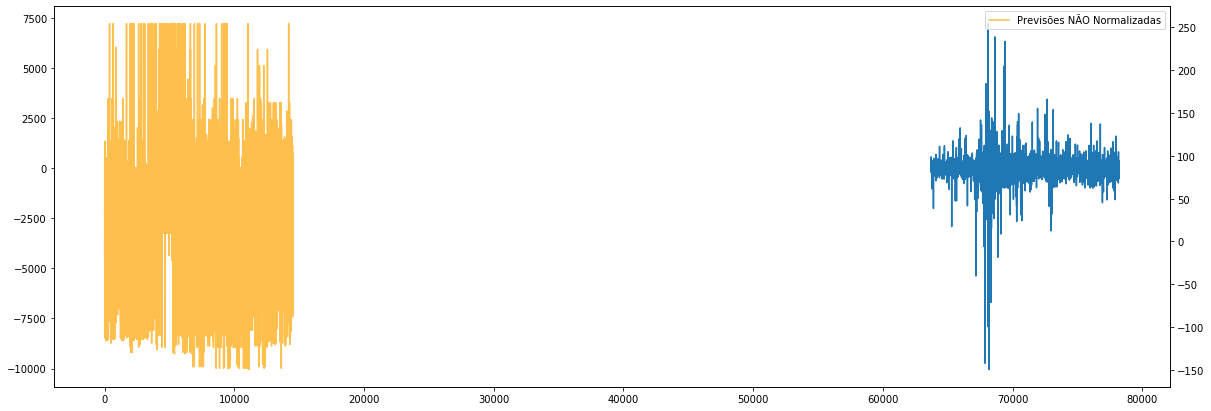

In [54]:
fig, ax = plb.subplots(1,1,figsize=(20,7))
ax.plot(ytest, label = 'Y')
axt = ax.twinx()
axt.plot(predict_RF, color = 'orange', alpha = 0.7, label='Previsões NÃO Normalizadas')
axt.legend()

In [28]:
model_random_forest_ss = RandomForestRegressor(n_jobs=-1, random_state=0, n_estimators=2, min_samples_leaf=128, max_features='auto')
model_random_forest_ss.fit(xtrain_ss, ytrain_ss)
predict_RF_ss = model_random_forest_ss.predict(xtest_ss)

In [46]:
final_price_predicted_ss = xtest_ss['CLOSE_1'] + predict_RF_ss
final_price_test_ss = xtest_ss['CLOSE_1'] + ytest_ss

print('MAE_ss: ', mean_absolute_error(final_price_test_ss, final_price_predicted_ss))
print('MSE_ss: ', mean_squared_error(final_price_test_ss, final_price_predicted_ss))

MAE_ss:  0.5282114159326748
MSE_ss:  1.0644002249436886


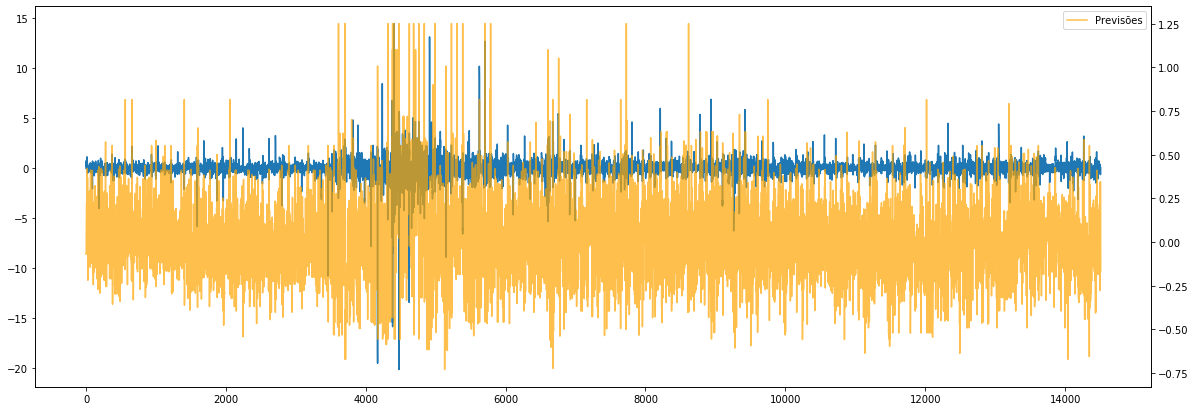

In [53]:
fig, ax = plb.subplots(1,1,figsize=(20,7))
ax.plot(ytest_ss, label = 'Y')
axt = ax.twinx()
axt.plot(predict_RF_ss, color = 'orange', alpha = 0.7, label='Previsões')
axt.legend()

### Ridge

In [48]:
model_ridge = Ridge(random_state=0, alpha=100000.)
model_ridge.fit(xtrain, ytrain)
predict_rg = model_ridge.predict(xtest)

C:\Users\auW10\Anaconda3\envs\projetoPhoenix\lib\site-packages\sklearn\linear_model\ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.49334e-18): result may not be accurate.
  overwrite_a=True).T


In [49]:
final_price_predicted = xtest['CLOSE_1'] + predict_rg
final_price_test = xtest['CLOSE_1'] + ytest

print('ERRO: ', np.sqrt(mean_squared_log_error(final_price_test, final_price_predicted)) * 100)
print('MAE: ', mean_absolute_error(final_price_test, final_price_predicted))
print('MSE: ', mean_squared_error(final_price_test, final_price_predicted))

ERRO:  0.6208156881478888
MAE:  264.1460140970716
MSE:  260504.82955845929


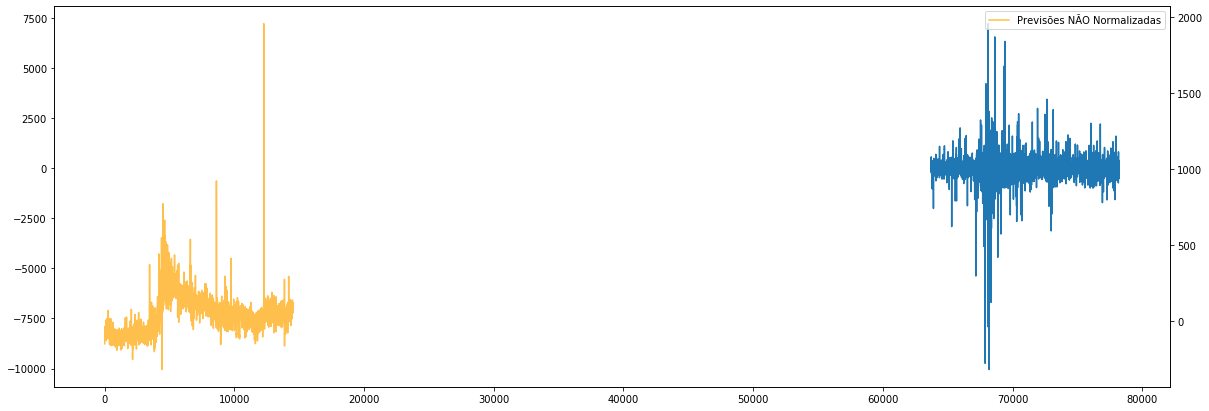

In [56]:
fig, ax = plb.subplots(1,1,figsize=(20,7))
ax.plot(ytest, label = 'Y')
axt = ax.twinx()
axt.plot(predict_rg, color = 'orange', alpha = 0.7, label='Previsões NÃO Normalizadas')
axt.legend()

In [50]:
model_ridge_ss = Ridge(random_state=0, alpha=100000.)
model_ridge_ss.fit(xtrain_ss, ytrain_ss)
predict_rg_ss = model_ridge_ss.predict(xtest_ss)

In [51]:
final_price_predicted_ss = xtest_ss['CLOSE_1'] + predict_rg_ss
final_price_test_ss = xtest_ss['CLOSE_1'] + ytest_ss

print('MAE_ss: ', mean_absolute_error(final_price_test_ss, final_price_predicted_ss))
print('MSE_ss: ', mean_squared_error(final_price_test_ss, final_price_predicted_ss))

MAE_ss:  0.4976394163213321
MSE_ss:  1.0007943465980835


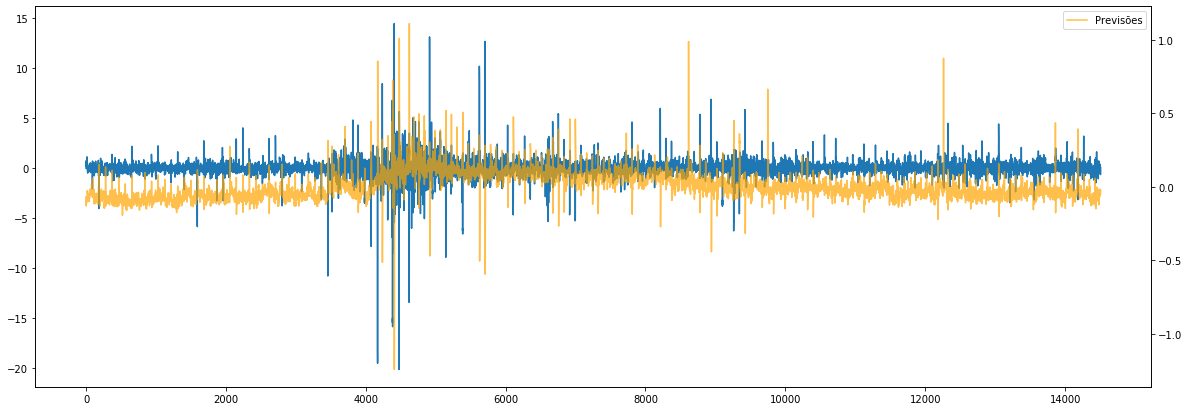

In [38]:
fig, ax = plb.subplots(1,1,figsize=(20,7))
ax.plot(ytest_ss, label = 'Y')
axt = ax.twinx()
axt.plot(predict_rg_ss, color = 'orange', alpha = 0.7, label='Previsões')
axt.legend()